<a href="https://colab.research.google.com/github/allen44/econometric-time-series-study/blob/main/econometric_time_series_study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup

In [1]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/API Keys')
import config
API_KEY = config.API_KEY

%cd /content/drive/MyDrive/Colab Notebooks/econ-data-time-series-study

/content/drive/MyDrive/Colab Notebooks/econ-data-time-series-study


In [2]:
import os

try:
  import requests_cache
except ModuleNotFoundError:
  os.system("pip install requests_cache")
  import requests_cache

try:
  import alphalens
except ModuleNotFoundError:
  os.system("pip install alphalens")
  import alphalens

try:
  import pmdarima
except ModuleNotFoundError:
  os.system("pip install pmdarima")
  import pmdarima

try:
  import hcrystalball
except ModuleNotFoundError:
  os.system("pip install hcrystalball")
  import hcrystalball


In [3]:
!pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)


In [4]:
import datetime
import pandas_datareader.data as web
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [12, 6]

#pandas_datareader setup
expire_after = datetime.timedelta(days=3)
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite', expire_after=expire_after)
start = datetime.datetime(2018, 1, 1)
end = datetime.datetime(2021, 1, 1)

# Historical Time Series Data from AlphaVantage

## Docs

https://pandas-datareader.readthedocs.io/en/latest/readers/alphavantage.html#module-pandas_datareader.av.time_series

>
>Through the [Alpha Vantage](https://www.alphavantage.co/documentation) Time >Series endpoints, it is possible to obtain historical equities and currency >rate data for individual symbols. For daily, weekly, and monthly frequencies, 20>+ years of historical data is available. The past 3-5 days of intraday data is >also available.
>
>The following endpoints are available:
>
>*   `av-intraday` - Intraday Time Series
>    
>*   `av-daily` - Daily Time Series
>    
>*   `av-daily-adjusted` - Daily Time Series (Adjusted)
>    
>*   `av-weekly` - Weekly Time Series
>    
>*   `av-weekly-adjusted` - Weekly Time Series (Adjusted)
>    
>*   `av-monthly` - Monthly Time Series
>    
>*   `av-monthly-adjusted` - Monthly Time Series (Adjusted)
>    
>*   `av-forex-daily` - Daily Time Series
>
>To request the historical exchange rate of physical or digital currencies, use >`av-forex-daily` and format the symbol as “FROM/TO”, for example “USD/JPY”.
>
>The top-level function `get_data_alphavantage` is also provided. This function >will return the `TIME_SERIES_DAILY` endpoint for the symbol and date range >provided.

In [138]:
# Get single stock prices
def get_stock_time_series(name="AAPL",
                          start=start, 
                          end=end,
                          column='adjusted close'):
  df = web.DataReader(name=name, 
                        data_source="av-daily-adjusted", 
                        start=start,
                        end=end,
                        session=session,
                        api_key=API_KEY['alphavantage'])
  df.index = pd.to_datetime(df.index).rename('date')
  df.resample('B').asfreq()
  if column:
    s = df[column].rename(name)
    return s
  return df

get_stock_time_series()

date
2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

# Get FX pair prices from AlphaVantage

https://pandas-datareader.readthedocs.io/en/latest/readers/alphavantage.html#module-pandas_datareader.av.forex

In [139]:
# Get single FX prices
def get_fx_time_series(name="USDJPY", 
                       start=start, 
                       end=end,
                       column='close'):
  df = web.DataReader(name=name,
                    data_source="av-daily", 
                    start=start,
                    end=end,
                    session=session,
                    api_key=API_KEY['alphavantage'])
  df.index = pd.to_datetime(df.index).rename('date')
  df.resample('B').asfreq()
  if column:
    s = df[column].rename(name)
    return s
  return df

get_fx_time_series()

date
2018-01-01    112.586
2018-01-02    112.227
2018-01-03    112.543
2018-01-04    112.775
2018-01-05    112.985
               ...   
2020-12-28    103.789
2020-12-29    103.560
2020-12-30    103.182
2020-12-31    103.259
2021-01-01    103.191
Name: USDJPY, Length: 785, dtype: float64

In [7]:
 real_gdp_us = web.DataReader('ticker=RGDPUS', 'econdb')
 real_gdp_us.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19 entries, 2016-07-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column                                                                                                                                                                                                                                               Non-Null Count  Dtype
---  ------                                                                                                                                                                                                                                               --------------  -----
 0   (T10106, A191RX, Table 1.1.6. Real Gross Domestic Product, Chained Dollars (A) (Q), Gross domestic product, Level, Q, Table 1.1.6. Real Gross Domestic Product, Chained Dollars [Billions of chained (2012) dollars] - LastRevised: April 29, 2021)  19 non-null     int64
dtypes: int64(1)
memory usage: 304.0 bytes


In [8]:
 fred_data_series_list = ['DAAA', 
                         'UNRATE', 
                         'PPIACO', 
                         'CPIAUCSL', 
                         'PERMIT', 
                         'UMCSENT', 
                         'CABPPRIVSA',
                         'VIXCLS']
 
fred_data = web.DataReader(name=fred_data_series_list,  
                           data_source='fred', 
                           start=start, 
                           end=end, 
                           session=session).resample('B').asfreq()
fred_data

,DAAA,UNRATE,PPIACO,CPIAUCSL,PERMIT,UMCSENT,CABPPRIVSA,VIXCLS
DATE,,,,,,,,
2018-01-01,NaN,4.0,197.9,248.721,1365.0,95.7,9602.284476,NaN
2018-01-02,3.52,NaN,NaN,NaN,NaN,NaN,NaN,9.77
2018-01-03,3.50,NaN,NaN,NaN,NaN,NaN,NaN,9.15
2018-01-04,3.47,NaN,NaN,NaN,NaN,NaN,NaN,9.22
2018-01-05,3.50,NaN,NaN,NaN,NaN,NaN,NaN,9.22
...,...,...,...,...,...,...,...,...
2020-12-28,2.25,NaN,NaN,NaN,NaN,NaN,NaN,21.70
2020-12-29,2.25,NaN,NaN,NaN,NaN,NaN,NaN,23.08
2020-12-30,2.22,NaN,NaN,NaN,NaN,NaN,NaN,22.77


## Dynamic forecasting with SARIMAX

In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

name='AAPL'
time_series = get_stock_time_series(name=name)

def sarimax_forecast(endog=time_series,
                     exog=None,
                     order=(1,1,1),
                     seasonal_order=(0,0,0,0),
                     start=-30,
                     dynamic=True):
  from statsmodels.tsa.statespace.sarimax import SARIMAX
  model = SARIMAX(endog=time_series,
                  exog=exog,
                  order=order,
                  seasonal_order=seasonal_order)
  results=model.fit()

  # Generate predictions
  dynamic_forecast = results.get_prediction(start=start, dynamic=dynamic)

  # Extract prediction mean
  mean_forecast = dynamic_forecast.predicted_mean

  # Get confidence intervals of predictions
  confidence_intervals = dynamic_forecast.conf_int()

  # Select lower and upper confidence limits
  lower_limits = confidence_intervals.loc[:,f'lower {time_series.name}']
  upper_limits = confidence_intervals.loc[:,f'upper {time_series.name}']

  # # Print best estimate predictions
  # print(mean_forecast)
  return mean_forecast, lower_limits, upper_limits
sarimax_forecast()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


(2020-11-18    119.162050
 2020-11-19    119.109426
 2020-11-20    119.127666
 2020-11-23    119.121344
 2020-11-24    119.123535
 2020-11-25    119.122776
 2020-11-27    119.123039
 2020-11-30    119.122948
 2020-12-01    119.122979
 2020-12-02    119.122968
 2020-12-03    119.122972
 2020-12-04    119.122971
 2020-12-07    119.122971
 2020-12-08    119.122971
 2020-12-09    119.122971
 2020-12-10    119.122971
 2020-12-11    119.122971
 2020-12-14    119.122971
 2020-12-15    119.122971
 2020-12-16    119.122971
 2020-12-17    119.122971
 2020-12-18    119.122971
 2020-12-21    119.122971
 2020-12-22    119.122971
 2020-12-23    119.122971
 2020-12-24    119.122971
 2020-12-28    119.122971
 2020-12-29    119.122971
 2020-12-30    119.122971
 2020-12-31    119.122971
 Name: predicted_mean, dtype: float64, 2020-11-18    115.987439
 2020-11-19    114.914742
 2020-11-20    114.032784
 2020-11-23    113.288488
 2020-11-24    112.628207
 2020-11-25    112.029068
 2020-11-27    111.476833


Plotting dynamic forecasts

In [10]:
time_series
# time_series.index = pd.DatetimeIndex(time_series.index).to_period('B')

2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


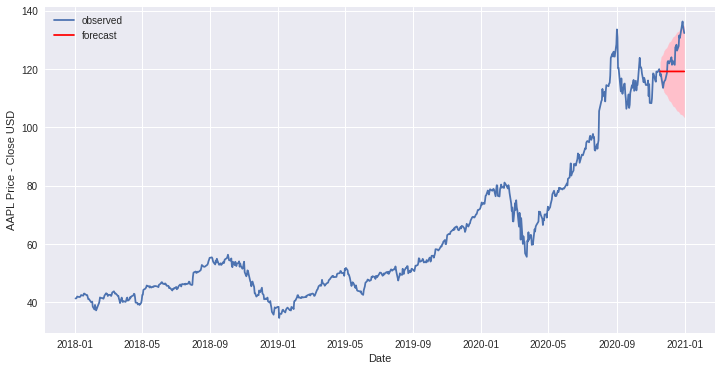

In [11]:
name='AAPL'
time_series = get_stock_time_series(name=name)

def plot_dynamic_forecast(endog=time_series,
                          exog=None,
                          order=(1,1,1),
                          seasonal_order=(0,0,0,0)):
  (mean_forecast, 
  lower_limits, 
  upper_limits) = sarimax_forecast(endog=time_series,
                                  exog=exog,
                                  order=order,
                                  seasonal_order=seasonal_order)
  # plot the observed data
  plt.plot(endog.index, endog, label='observed')

  # plot your mean forecast
  plt.plot(mean_forecast.index, mean_forecast, color='r', label='forecast')

  # shade the area between your confidence limits
  plt.fill_between(lower_limits.index, lower_limits, 
          upper_limits, color='pink')

  # set labels, legends and show plot
  plt.xlabel('Date')
  plt.ylabel(f'{name} Price - Close USD')
  plt.legend()
  plt.show()

plot_dynamic_forecast()

Box-Jenkins Method: identify, estimate, model, diagnostics

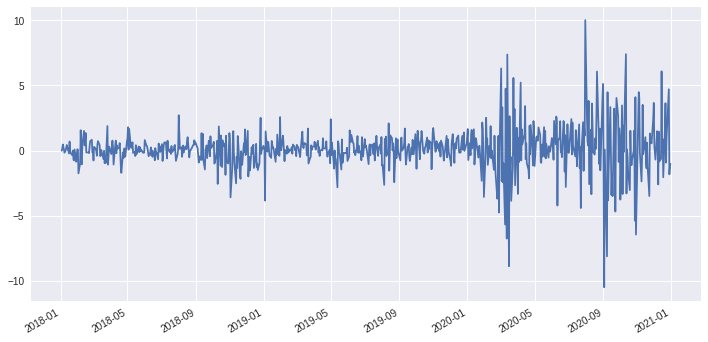

test statistic: -8.443930110470156
p-value: 1.7332051602480466e-13
Data is stationary.


True

In [12]:
def indentification(series_with_unknown_charecteristics):
  from statsmodels.tsa.stattools import adfuller
  # Check for stationarity
  # Plot time series
  series_with_unknown_charecteristics.plot()
  plt.show()

  # Run Dicky-Fuller test
  result = adfuller(series_with_unknown_charecteristics)

  # Print test statistic
  print(f'test statistic: {result[0]}')

  # Print p-value
  print(f'p-value: {result[1]}')

  if result[1] < 0.05: 
    print('Data is stationary.')
    stationary_series = series_with_unknown_charecteristics
    return True
  else:
    print('Data is not stationary')
    return False
indentification(time_series.diff().dropna())

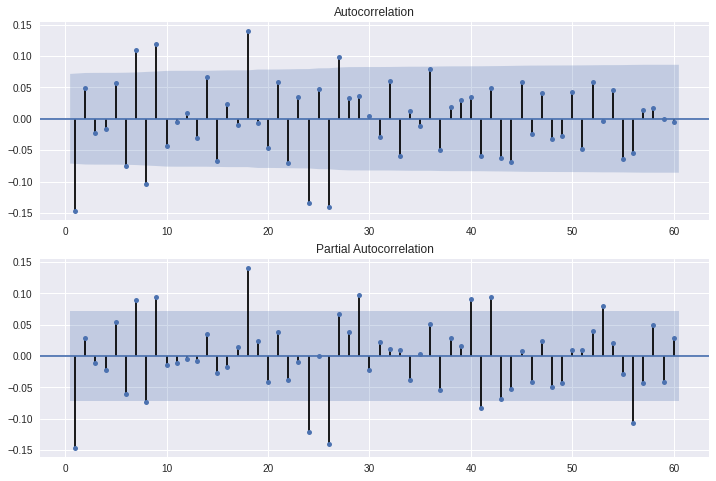

True

In [13]:
def indentification_2(series_stationary):
  from statsmodels.tsa.stattools import adfuller
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  # Identify what order of model will be the best fit.
  # Create figure
  fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,8))
  
  # Plot the ACF of savings on ax1
  plot_acf(series_stationary, lags=60, zero=False, ax=ax1)

  # Plot the PACF of savings on ax2
  plot_pacf(series_stationary, lags=60, zero=False, ax=ax2)

  plt.show()
  adf_p_value = adfuller(series_stationary)[1]
  is_stationary = True if adf_p_value<0.05 else False
  assert is_stationary
  return True
indentification_2(time_series.diff().dropna())

In [14]:
def estimation(series_stationary, p_range=range(4), q_range=range(4)):
  from statsmodels.tsa.stattools import adfuller
  adf_p_value = adfuller(series_stationary)[1]
  is_stationary = True if adf_p_value<0.05 else False
  assert is_stationary

  from statsmodels.tsa.statespace.sarimax import SARIMAX
  order_aic_bic=[]
  # Loop over p values from 0-3
  for p in p_range:
    # Loop over q values from 0-3
      for q in q_range:
        try:
          # Create and fit ARMA(p,q) model
          model = SARIMAX(series_stationary, order=(p,0,q), trend='c')
          results = model.fit()
          
          # Print p, q, AIC, BIC
          print(p, q, results.aic, results.bic)
          order_aic_bic.append((p, q, results.aic, results.bic))
        except:
          print(p, q, None, None)

  # Choose the best results
  # Construct DataFrame from order_aic_bic
  order_df = pd.DataFrame(order_aic_bic, 
                          columns=['p', 'q', 'AIC', 'BIC'])

  # Print order_df in order of increasing AIC
  print(order_df.sort_values('AIC'))
  best_aic_order = (order_df.sort_values('AIC')['p'][0],
                    0,
                    order_df.sort_values('AIC')['q'][0],)
  
  # Print order_df in order of increasing BIC
  print(order_df.sort_values('BIC'))
  best_bic_order = (order_df.sort_values('BIC')['p'][0],
                    0,
                    order_df.sort_values('BIC')['q'][0],)
  if best_aic_order == best_bic_order:
    print(f'best_aic_order=best_bic_order = {best_aic_order}')
  else:
    print(f'best_aic_order: {best_aic_order}')
    print(f'best_aic_order: {best_bic_order}')

  return order_aic_bic, best_aic_order, best_bic_order
estimation(time_series.diff().dropna())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

0 0 2886.539838221585 2895.793273720083
0 1 2873.347469289194 2887.227622536941
0 2 2873.9065393386554 2892.4134103356514


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 3 2875.3018087005626 2898.4353974468077
1 0 2872.233116569554 2886.113269817301


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

1 1 2873.5976473250385 2892.1045183220344


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 2 2875.573391714389 2898.706980460634


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

1 3 2877.297811988777 2905.0581184842713
2 0 2873.611333173654 2892.11820417065


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

2 1 2875.580777568518 2898.714366314763


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2 2877.596606834173 2905.3569133296673


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib

2 3 2848.2088195922247 2880.595843836968
3 0 2875.5167164488175 2898.6503051950626


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 1 2877.471171774021 2905.2314782695153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib

3 2 2874.537546066658 2906.924570311401
3 3 2854.915709128526 2891.929451122518
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
15  3  3  2854.915709  2891.929451
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
14  3  2  2874.537546  2906.924570
3   0  3  2875.301809  2898.435397
12  3  0  2875.516716  2898.650305
6   1  2  2875.573392  2898.706980
9   2  1  2875.580778  2898.714366
7   1  3  2877.297812  2905.058118
13  3  1  2877.471172  2905.231478
10  2  2  2877.596607  2905.356913
0   0  0  2886.539838  2895.793274
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
15  3  3  2854.915709  2891.929451
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
0   0  0  2886.539838  2895.793274
3   0  3  

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


([(0, 0, 2886.539838221585, 2895.793273720083),
  (0, 1, 2873.347469289194, 2887.227622536941),
  (0, 2, 2873.9065393386554, 2892.4134103356514),
  (0, 3, 2875.3018087005626, 2898.4353974468077),
  (1, 0, 2872.233116569554, 2886.113269817301),
  (1, 1, 2873.5976473250385, 2892.1045183220344),
  (1, 2, 2875.573391714389, 2898.706980460634),
  (1, 3, 2877.297811988777, 2905.0581184842713),
  (2, 0, 2873.611333173654, 2892.11820417065),
  (2, 1, 2875.580777568518, 2898.714366314763),
  (2, 2, 2877.596606834173, 2905.3569133296673),
  (2, 3, 2848.2088195922247, 2880.595843836968),
  (3, 0, 2875.5167164488175, 2898.6503051950626),
  (3, 1, 2877.471171774021, 2905.2314782695153),
  (3, 2, 2874.537546066658, 2906.924570311401),
  (3, 3, 2854.915709128526, 2891.929451122518)],
 (0, 0, 0),
 (0, 0, 0))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


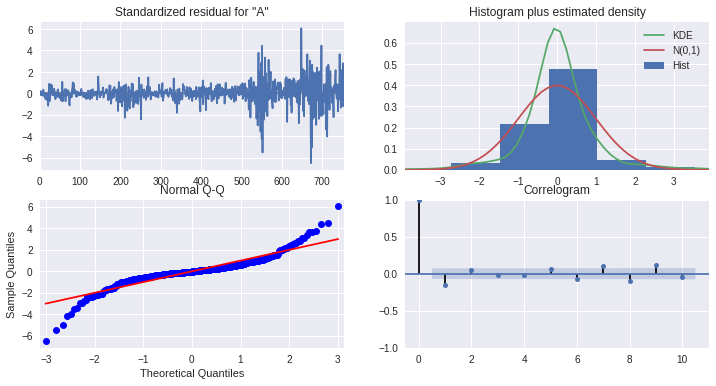

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  755
Model:                        SARIMAX   Log Likelihood               -1441.270
Date:                Sat, 15 May 2021   AIC                           2886.540
Time:                        19:18:04   BIC                           2895.793
Sample:                             0   HQIC                          2890.104
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1205      0.060      2.023      0.043       0.004       0.237
sigma2         2.6646      0.060     44.448      0.000       2.547       2.782
Ljung-Box (L1) (Q):                  16.21   Jarque-

In [15]:
def diagnostics(series_stationary, p, q):
  # Create and fit model
  model = SARIMAX(series_stationary, order=(p,0,q), trend='c')
  results = model.fit()

  # Create the 4 diagostics plots
  results.plot_diagnostics()
  plt.show()

  # Print summary
  print(results.summary())
diagnostics(time_series.diff().dropna(), 0,0)

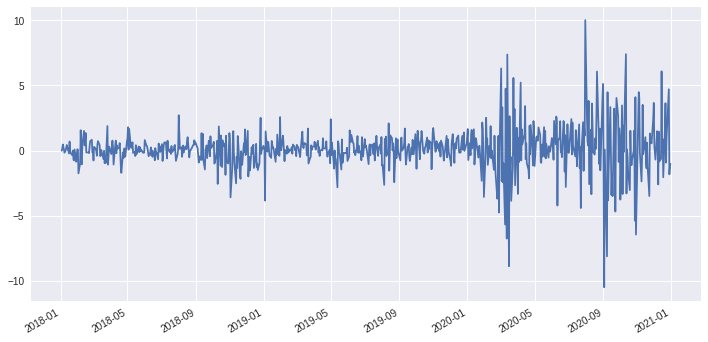

test statistic: -8.443930110470156
p-value: 1.7332051602480466e-13
Data is stationary.


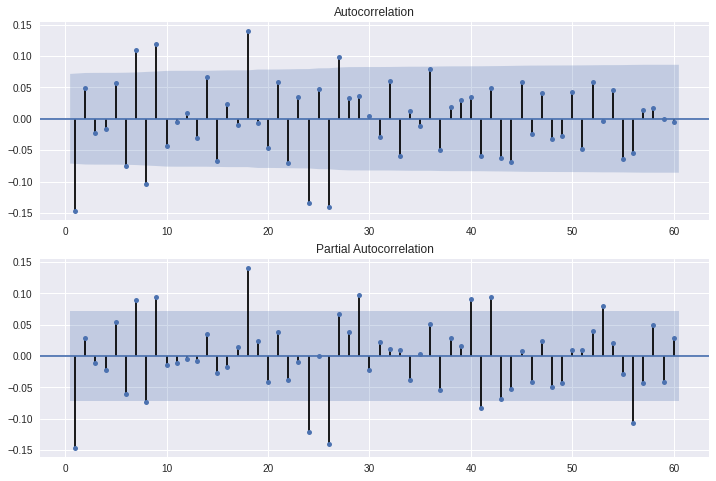

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

0 0 2886.539838221585 2895.793273720083
0 1 2873.347469289194 2887.227622536941
0 2 2873.9065393386554 2892.4134103356514


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


0 3 2875.3018087005626 2898.4353974468077
1 0 2872.233116569554 2886.113269817301


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

1 1 2873.5976473250385 2892.1045183220344


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


1 2 2875.573391714389 2898.706980460634


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parame

1 3 2877.297811988777 2905.0581184842713
2 0 2873.611333173654 2892.11820417065


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored wh

2 1 2875.580777568518 2898.714366314763


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


2 2 2877.596606834173 2905.3569133296673


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib

2 3 2848.2088195922247 2880.595843836968
3 0 2875.5167164488175 2898.6503051950626


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 1 2877.471171774021 2905.2314782695153


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib

3 2 2874.537546066658 2906.924570311401


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


3 3 2854.915709128526 2891.929451122518
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
15  3  3  2854.915709  2891.929451
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
14  3  2  2874.537546  2906.924570
3   0  3  2875.301809  2898.435397
12  3  0  2875.516716  2898.650305
6   1  2  2875.573392  2898.706980
9   2  1  2875.580778  2898.714366
7   1  3  2877.297812  2905.058118
13  3  1  2877.471172  2905.231478
10  2  2  2877.596607  2905.356913
0   0  0  2886.539838  2895.793274
    p  q          AIC          BIC
11  2  3  2848.208820  2880.595844
4   1  0  2872.233117  2886.113270
1   0  1  2873.347469  2887.227623
15  3  3  2854.915709  2891.929451
5   1  1  2873.597647  2892.104518
8   2  0  2873.611333  2892.118204
2   0  2  2873.906539  2892.413410
0   0  0  2886.539838  2895.793274
3   0  3  2875.301809  2898.435397
12  3  0  2875.

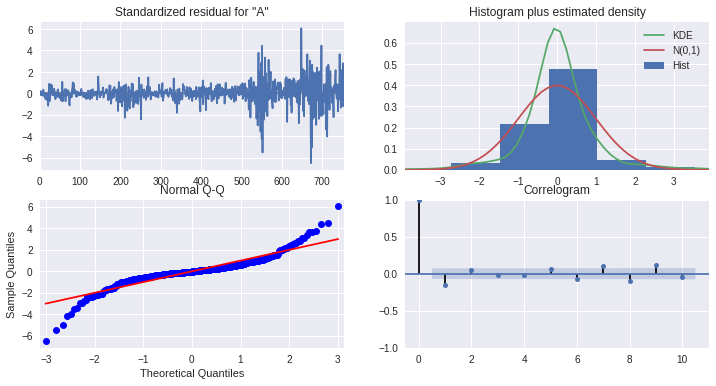

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                  755
Model:                        SARIMAX   Log Likelihood               -1441.270
Date:                Sat, 15 May 2021   AIC                           2886.540
Time:                        19:18:14   BIC                           2895.793
Sample:                             0   HQIC                          2890.104
                                - 755                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1205      0.060      2.023      0.043       0.004       0.237
sigma2         2.6646      0.060     44.448      0.000       2.547       2.782
Ljung-Box (L1) (Q):                  16.21   Jarque-

In [16]:
def box_jenkins_method(series_with_unknown_charecteristics):
  if indentification(series_with_unknown_charecteristics):
    if indentification_2(series_with_unknown_charecteristics):
      (order_aic_bic,
      best_aic_order,
      best_bic_order) = estimation(series_with_unknown_charecteristics, p_range=range(4), q_range=range(4))
      
      diagnostics(series_with_unknown_charecteristics, 
                  p=best_aic_order[0],
                  q=best_aic_order[2])
box_jenkins_method(time_series.diff().dropna())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  


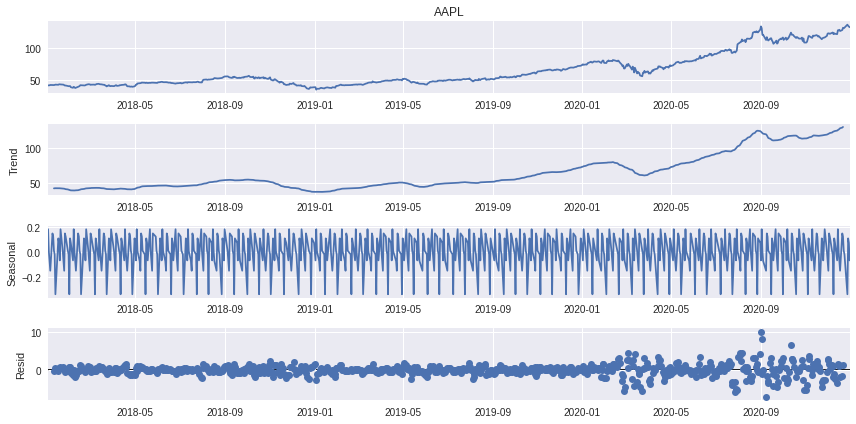

In [17]:
def plot_trend_seasonality_and_residuals(series,
                                         freq=12):
  # Import seasonal decompose
  from statsmodels.tsa.seasonal import seasonal_decompose

  # Perform additive decomposition
  decomp = seasonal_decompose(series, 
                              freq=freq)

  # Plot decomposition
  decomp.plot()
  plt.show()
plot_trend_seasonality_and_residuals(time_series)

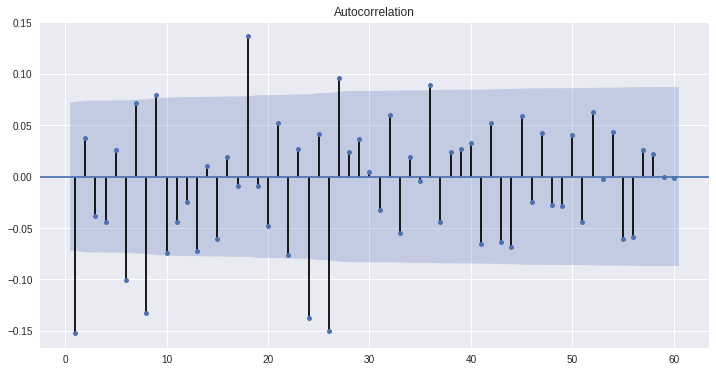

In [18]:
def plot_seasonal_acf_and_pacf(series):
  from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
  # Subtract the rolling mean to detrend it
  series_2 = series - series.rolling(15).mean()

  # Drop the NaN values
  series_2 = series_2.dropna()

  # Create figure and subplots
  fig, ax1 = plt.subplots()

  # Plot the ACF
  plot_acf(series_2, lags=60, zero=False, ax=ax1)

  # Show figure
  plt.show()

  # Remember: Seasonaility period is the first significant peak 
plot_seasonal_acf_and_pacf(time_series.diff().dropna())

Performing stepwise search to minimize oob
 ARIMA(0,1,0)(0,0,0)[5] intercept   : OOB=1.320, Time=0.10 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : OOB=1.706, Time=0.41 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : OOB=1.726, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[5]             : OOB=1.054, Time=0.06 sec
 ARIMA(0,1,0)(1,0,0)[5] intercept   : OOB=1.186, Time=0.29 sec
 ARIMA(0,1,0)(0,0,1)[5] intercept   : OOB=1.175, Time=0.29 sec
 ARIMA(0,1,0)(1,0,1)[5] intercept   : OOB=1.144, Time=0.62 sec
 ARIMA(1,1,0)(0,0,0)[5] intercept   : OOB=1.783, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[5] intercept   : OOB=1.817, Time=0.22 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : OOB=1.599, Time=0.39 sec

Best model:  ARIMA(0,1,0)(0,0,0)[5]          
Total fit time: 2.941 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  756
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1443.321
Date:        

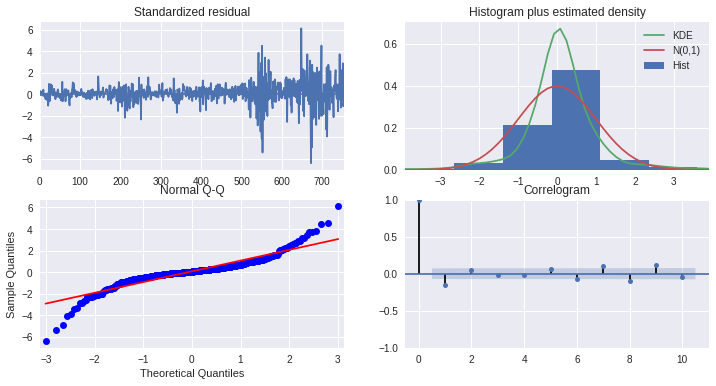

In [23]:
def auto_arima(y=time_series,
                        seasonal=True,
                        m=7,
                        start_p=0, 
                        start_d=0,
                        start_q=0,
                        max_p=3, 
                        max_d=3,
                        max_q=3,
                        start_P=0, 
                        start_D=0,
                        start_Q=0,
                        max_P=3,
                        max_D=3, 
                        max_Q=3,
                        information_criterion='aic',
                        out_of_sample_size = 0,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True):
  import pmdarima as pm

  # Create model for SARIMAX(p,1,q)(P,1,Q)7
  pm_model = pm.auto_arima(y=time_series ,
                        seasonal=seasonal, 
                        m=m,
                        start_p=start_p,
                        start_d=start_d,
                        start_q=start_q,
                        max_p=max_p,
                        max_d=max_d,
                        max_q=max_q,
                        start_P=start_P,
                        start_D=start_D,
                        start_Q=start_Q,
                        max_P=max_P,
                        max_D=max_D,
                        max_Q=max_Q,
                        information_criterion=information_criterion,
                        out_of_sample_size = out_of_sample_size,
                        trace=trace,
                        error_action=error_action,
                        suppress_warnings=suppress_warnings) 

  # Print model summary
  print(pm_model.summary())

  # Plot common diagnostics
  pm_model.plot_diagnostics()
  plt.show()

  return pm_model
  
model = auto_arima(y=time_series, m=5, information_criterion='oob', out_of_sample_size=1)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[21] intercept   : AIC=2886.540, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[21] intercept   : AIC=2872.712, Time=0.70 sec
 ARIMA(0,1,1)(0,0,1)[21] intercept   : AIC=2873.840, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[21]             : AIC=2888.641, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[21] intercept   : AIC=2872.233, Time=0.08 sec
 ARIMA(1,1,0)(0,0,1)[21] intercept   : AIC=2872.802, Time=0.60 sec
 ARIMA(1,1,0)(1,0,1)[21] intercept   : AIC=2873.024, Time=3.40 sec
 ARIMA(2,1,0)(0,0,0)[21] intercept   : AIC=2873.611, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[21] intercept   : AIC=2873.598, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[21] intercept   : AIC=2873.347, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[21] intercept   : AIC=2875.581, Time=0.38 sec
 ARIMA(1,1,0)(0,0,0)[21]             : AIC=2875.721, Time=0.04 sec

Best model:  ARIMA(1,1,0)(0,0,0)[21] intercept
Total fit time: 6.435 seconds
                               SARIMAX Results                             

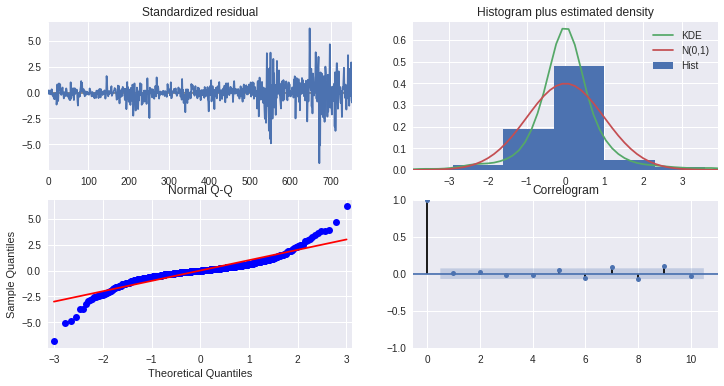

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 21),
      suppress_warnings=True)

In [24]:
auto_arima(y=time_series, m=21)

# HCrystalBall Wrappers

In [107]:
df

2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

In [168]:
from hcrystalball.utils import get_sales_data

# df = get_sales_data(n_dates=100,
                    # n_assortments=1,
                    # n_states=1,
                    # n_stores=1)
# X, y = pd.DataFrame(index=df.index), df['Sales']
aapl = get_stock_time_series('AAPL')
X, y =  pd.DataFrame(index=aapl.index), aapl

In [171]:
X

""
date
2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-08
...
2020-12-24
2020-12-28
2020-12-29


In [150]:
y

date
2018-01-02     41.308268
2018-01-03     41.301074
2018-01-04     41.492916
2018-01-05     41.965325
2018-01-08     41.809454
                 ...    
2020-12-24    131.550212
2020-12-28    136.255198
2020-12-29    134.440987
2020-12-30    133.294645
2020-12-31    132.267922
Name: AAPL, Length: 756, dtype: float64

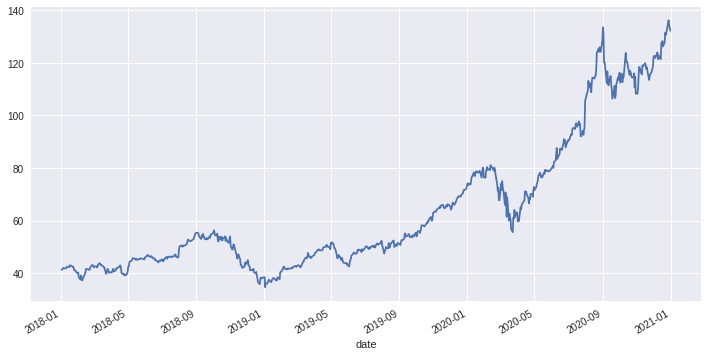

In [151]:
y.plot()

In [152]:
from hcrystalball.wrappers import ProphetWrapper
model = ProphetWrapper()
model.fit(X[:-10], y[:-10])
model.predict(X[-10:])

,prophet
date,
2020-12-17,121.599364
2020-12-18,121.514814
2020-12-21,121.792147
2020-12-22,122.021874
2020-12-23,122.254589
2020-12-24,122.225577
2020-12-28,122.564534
2020-12-29,122.862335
2020-12-30,123.175384


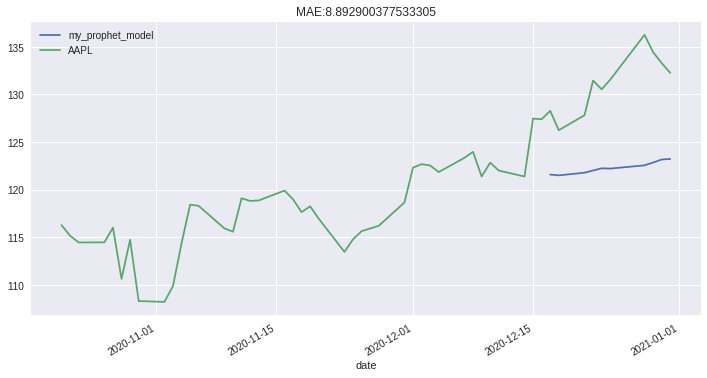

In [155]:
X, y = pd.DataFrame(index=aapl.index), aapl

# Model Name
model = ProphetWrapper(name = "my_prophet_model")

preds = (model.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['my_prophet_model']).abs().mean()}");

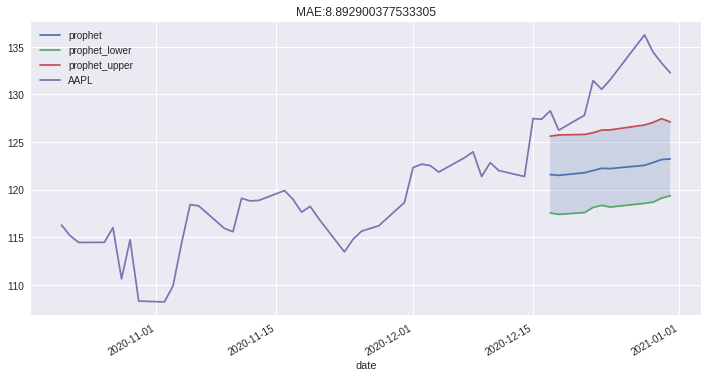

In [159]:
# Confidence Intervals
# All models which support confidence intervals in predictions have also 
# possibility to return them - they will be returned as 
# {name of the wrapper}_lower / _upper.

model = ProphetWrapper(conf_int=True)

preds = (model.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['prophet']).abs().mean()}")
plt.fill_between(preds['prophet'].index, preds['prophet_lower'], preds['prophet_upper'], alpha=0.2);

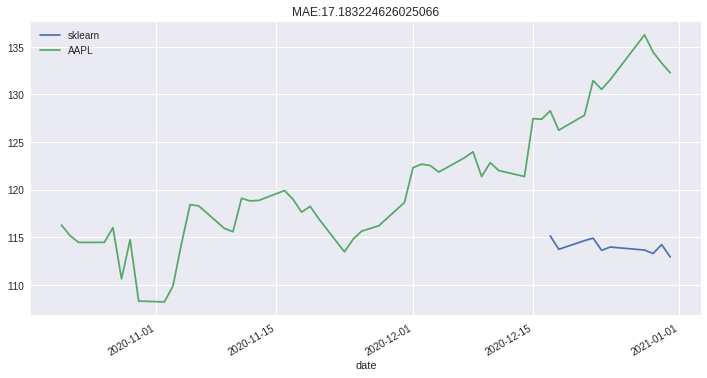

In [160]:
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor

X, y = pd.DataFrame(index=aapl.index), aapl

model = get_sklearn_wrapper(RandomForestRegressor, n_estimators=100, clip_predictions_lower=0., random_state=42)
preds = (model.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['sklearn']).abs().mean()}");

# Sklearn Pipelines

The best way to leverage whole sklearn landscape is to use TSColumnTransformer - it’s the hcrystalball implementation of ColumnTransformer which works on pandas dataframes and hcrystalball API, other functionality like pipeline, transformers can be leveraged with TSColumnTransformer directly from sklearn. hcrystalball’s own transformers do not need TSColumnTransformer, but might be used with it as well - depending on whether they work on column or index (or both)

## Building pipeline with exogenous variables

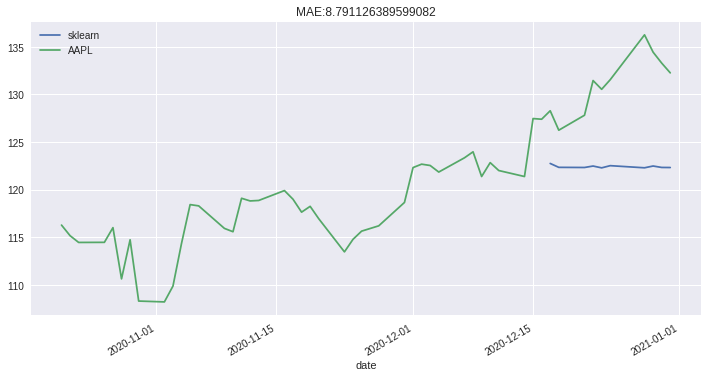

In [161]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import numpy as np

X, y = pd.DataFrame(index=aapl.index), aapl

# you can use standard sklearn transformations for your exogenous variables
X['trend'] = np.arange(len(X))
# add standard scaler to the trend and let the date column pass in raw form
sklearns_native_transformers = TSColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['trend'])
    ])
# define random forest model
rf_model = get_sklearn_wrapper(RandomForestRegressor, random_state=42)
# glue it together
sklearn_model_pipeline = Pipeline([
    ('sklearns_native_transformers', sklearns_native_transformers),
    ('seasonality', SeasonalityTransformer(auto=True, freq='D')),
    ('model', rf_model)
])
preds = (sklearn_model_pipeline.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)

preds.plot(title=f"MAE:{(preds['AAPL']-preds['sklearn']).abs().mean()}");

#Seasonality Features

In [164]:
from hcrystalball.feature_extraction import SeasonalityTransformer
SeasonalityTransformer(freq = 'D').fit(X, y).transform(X)

,trend,_Friday,_Monday,_Thursday,_Tuesday,_Wednesday,_1_week,_2_week,_3_week,_4_week,_5_week,_6_week,_7_week,_8_week,_9_week,_10_week,_11_week,_12_week,_13_week,_14_week,_15_week,_16_week,_17_week,_18_week,_19_week,_20_week,_21_week,_22_week,_23_week,_24_week,_25_week,_26_week,_27_week,_28_week,_29_week,_30_week,_31_week,_32_week,_33_week,_34_week,_35_week,_36_week,_37_week,_38_week,_39_week,_40_week,_41_week,_42_week,_43_week,_44_week,_45_week,_46_week,_47_week,_48_week,_49_week,_50_week,_51_week,_52_week,_53_week,_April,_August,_December,_February,_January,_July,_June,_March,_May,_November,_October,_September,_1_quarter,_2_quarter,_3_quarter,_4_quarter,_2018,_2019,_2020
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-01-03,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-01-04,2,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-01-05,3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-01-08,4,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,751,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2020-12-28,752,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
2020-12-29,753,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1


## Holiday Features
One of the important parts of time-series modeling is taking into account holidays which in most cases exhibit different behavior than it’s common. hcrystalball implements HolidayTransformer which returns column with string name of the holiday based on provided country ISO code for each date in the dataset (empty string if it’s not a holiday). All hcrystalball wrappers accept the output of HolidayTransformer and transform it into individual model formats. HolidayTransformer also supports some region specific holidays i.e. Germany state specific holidays, in that case the provided string shoule be in form country-region: i.e. ‘DE-HE’.


In [ ]:
from hcrystalball.feature_extraction import HolidayTransformer
HolidayTransformer(country_code = 'DE').fit(X, y).transform(X)

In [49]:
from hcrystalball.feature_extraction import HolidayTransformer
HolidayTransformer(country_code = 'DE', days_before = 2, days_after = 1, bridge_days = True).fit(X, y).transform(X)['2014-04-16':'2014-04-23']

,trend,_holiday_DE,_2_before_holiday_DE,_1_after_holiday_DE,_bridge_holiday_DE
Date,,,,,
2014-04-16,258,,True,False,False
2014-04-17,259,,True,False,False
2014-04-18,260,Good Friday,False,False,False
2014-04-19,261,,True,True,True
2014-04-20,262,,True,False,False
2014-04-21,263,Easter Monday,False,False,False
2014-04-22,264,,False,True,False
2014-04-23,265,,False,False,False


## In Pipelines
It is possible to combine more countries/regions for the holidays. The behovior of multi holidays is wrapper specific.


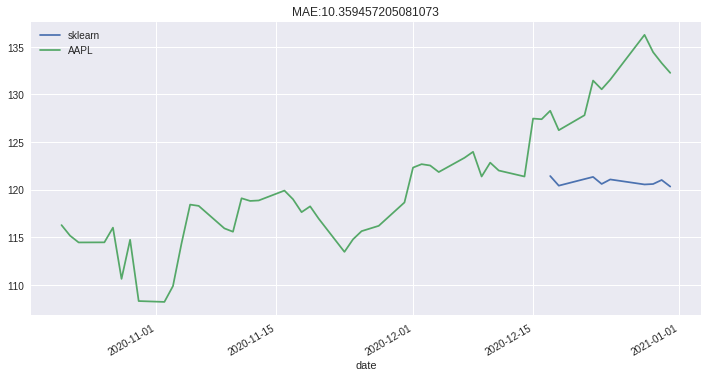

In [175]:
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.wrappers import ExponentialSmoothingWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from hcrystalball.wrappers import SarimaxWrapper

X, y = pd.DataFrame(index=aapl.index), aapl

pipeline = Pipeline([
    # ('holidays_de', HolidayTransformer(country_code = 'DE')),
    # ('holidays_be', HolidayTransformer(country_code = 'BE')),
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', get_sklearn_wrapper(RandomForestRegressor, random_state=42))
])
preds = (pipeline.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50))

preds.plot(title=f"MAE:{(preds['AAPL']-preds['sklearn']).abs().mean()}");

## Also country code column can be used.
Note: This column is deleted in ``HolidayTransformer.transform`` method in ordet to not pollute the further processing

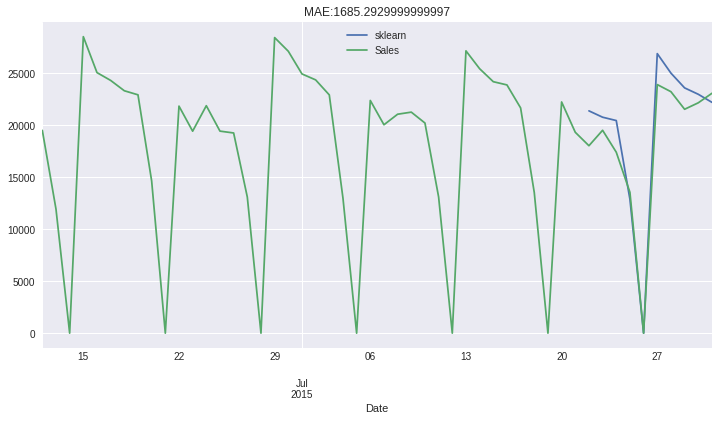

In [83]:
X, y = pd.DataFrame(index=df.index), df['Sales']

pipeline_col = Pipeline([
    ('holidays_de', HolidayTransformer(country_code_column = 'germany')),
    ('holidays_be', HolidayTransformer(country_code_column = 'belgium')),
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', get_sklearn_wrapper(RandomForestRegressor, random_state=42))
])

X_col = X.copy().assign(germany='DE').assign(belgium='BE')

preds_col = (pipeline_col.fit(X_col[:-10], y[:-10])
         .predict(X_col[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50))

preds_col.plot(title=f"MAE:{(preds_col['Sales'] - preds_col['sklearn']).abs().mean()}");

## With exogenous variables


In [ ]:
X, y = pd.DataFrame(index=aapl.index), aapl
X_col['trend'] = np.arange(len(X))
preds_col = (pipeline_col.fit(X_col[:-10], y[:-10])
         .predict(X_col[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50))

preds_col.plot(title=f"MAE:{(preds_col['AAPL'] - preds_col['sklearn']).abs().mean()}");

# Cross Validation
As time-series have the inherent structure we could run into problems with traditional shuffled Kfolds cross-validation. hcrystalball implements forward rolling cross-validation making training set consist only of observations that occurred prior to the observations that form the test set.


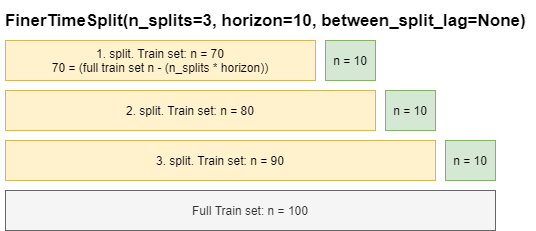

In [179]:
from hcrystalball.model_selection import FinerTimeSplit
from sklearn.model_selection import cross_validate
from hcrystalball.wrappers import ExponentialSmoothingWrapper
import pandas as pd
import matplotlib.pyplot as plt

X, y = pd.DataFrame(index=aapl.index), aapl
# plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [12, 6]


In [180]:
# Native Cross Validation
cross_validate(ExponentialSmoothingWrapper(),
               X,
               y,
               cv=FinerTimeSplit(horizon=5, n_splits=2),
               scoring='neg_mean_absolute_error')

{'fit_time': array([0.01348352, 0.00845623]),
 'score_time': array([0.0080657, 0.0058589]),
 'test_score': array([-1.98548554, -2.96350305])}

## Grid search and model selection
Model selection and parameter tuning is the area where hcrystalball really shines. There is ongoing and probably a never-ending discussion about superiority or inferiority of ML techniques over common statistical/econometrical ones. Why not try both? The problem of a simple comparison between the performance of different kind of algorithms such as SARIMAX, Prophet, regularized linear models, and XGBoost lead to hcrystalball. Let’s see how to do it!

In [181]:
from hcrystalball.compose import TSColumnTransformer
from hcrystalball.feature_extraction import SeasonalityTransformer
from hcrystalball.wrappers import ProphetWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

from hcrystalball.wrappers import SarimaxWrapper
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd

## Define our pipeline

In [182]:
sklearn_model_pipeline = Pipeline([
    ('seasonality', SeasonalityTransformer(freq='D')),
    ('model', 'passthrough') # this will be overwritten by param grid
])

## Define pipeline parameters including different models

In [183]:
param_grid = [{'model': [sklearn_model_pipeline],
               'model__model':[get_sklearn_wrapper(RandomForestRegressor, random_state=42),
                               get_sklearn_wrapper(LinearRegression)]},
              {'model': [ProphetWrapper()],
               'model__seasonality_mode':['multiplicative', 'additive']},
              {'model': [SarimaxWrapper(order=(2,1,1), suppress_warnings=True,
                                        init_with_autoarima=True)]}
             ]

## Run native grid search

In [184]:
grid_search = GridSearchCV(estimator=sklearn_model_pipeline,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=FinerTimeSplit(horizon=5, n_splits=2),
                           refit=False,
                           error_score=np.nan)
results = grid_search.fit(X, y)
pd.DataFrame(results.cv_results_).sort_values('rank_test_score').head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__model,param_model__seasonality_mode,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
2,4.293856,0.208531,1.739818,0.095408,"ProphetWrapper(changepoint_prior_scale=0.05, c...",NaN,multiplicative,{'model': ProphetWrapper(changepoint_prior_sca...,-1.042718,-1.731824e+00,-1.387271e+00,3.445532e-01,1
0,0.023413,0.000883,0.762995,0.009540,"(SeasonalityTransformer(auto=True, freq='D', m...","SklearnWrapper(bootstrap=True, ccp_alpha=0.0, ...",NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-5.389279,-7.446826e+00,-6.418053e+00,1.028774e+00,2
3,0.723997,0.041899,1.670530,0.027348,"ProphetWrapper(changepoint_prior_scale=0.05, c...",NaN,additive,{'model': ProphetWrapper(changepoint_prior_sca...,-7.037195,-8.578641e+00,-7.807918e+00,7.707231e-01,3
1,0.029757,0.008250,0.073456,0.011223,"(SeasonalityTransformer(auto=True, freq='D', m...","SklearnWrapper(clip_predictions_lower=None, cl...",NaN,"{'model': (SeasonalityTransformer(auto=True, f...",-4.543494,-1.293955e+09,-6.469773e+08,6.469773e+08,4
4,0.016648,0.003794,0.000000,0.000000,"SarimaxWrapper(always_search_model=False, auto...",NaN,NaN,{'model': SarimaxWrapper(always_search_model=F...,NaN,NaN,NaN,NaN,5


It seems that the best model is sklearn with RandomForestRegressor, but in time-series, it is often also a good idea to check how the forecasts look like. Unfortunately, this is not possible with sklearn. grid_search is returning just the results, not the predictions of individual models for different splits. hcrystalball thus implements special scoring functions that track all data from the grid_search.

## Custom scorer

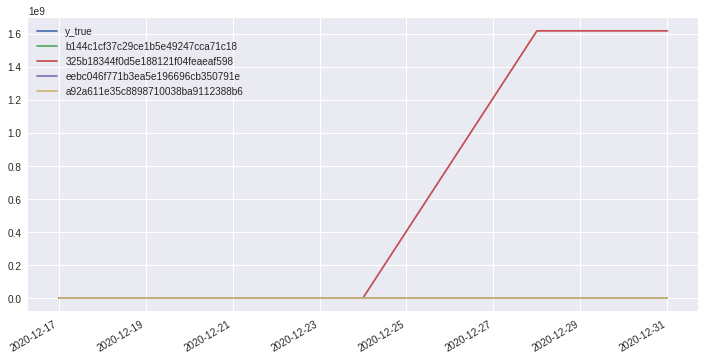

In [185]:
from hcrystalball.metrics import make_ts_scorer
from sklearn.metrics import mean_absolute_error

# X, y = pd.DataFrame(index=df.index), df['Sales']

scoring = make_ts_scorer(mean_absolute_error,
                         greater_is_better=False)
grid_search = GridSearchCV(estimator=sklearn_model_pipeline,
                           param_grid=param_grid,
                           scoring=scoring,
                           cv=FinerTimeSplit(horizon=5, n_splits=2),
                           refit=False,
                           error_score=np.nan)
results = grid_search.fit(X, y)
results.scorer_.cv_data.loc[:,lambda x: x.columns != 'split'].plot();

hcrystalball internally tracks data based on unique model hashes since model string represantations (reprs) are very long for usable columns names in dataframe, but if you are curious i.e. what was the worse model not to use it for further experiment, you can do it with scorers estimator_ids attribute

In [187]:
results.scorer_.cv_data

,split,y_true,b144c1cf37c29ce1b5e49247cca71c18,325b18344f0d5e188121f04feaeaf598,eebc046f771b3ea5e196696cb350791e,a92a611e35c8898710038ba9112388b6
2020-12-17,0,128.290613,122.982953,1.235916e+02,126.947393,121.599364
2020-12-18,0,126.252118,123.523035,1.227949e+02,127.119935,121.514814
2020-12-21,0,127.822108,122.799460,1.219206e+02,129.061114,121.792147
2020-12-22,0,131.460498,123.824570,1.262616e+02,129.902995,122.021874
2020-12-23,0,130.543425,124.292351,1.270826e+02,130.749468,122.254589
2020-12-24,1,131.550212,126.207341,1.297417e+02,130.721131,124.545854
2020-12-28,1,136.255198,126.747980,1.617443e+09,132.409261,124.759914
2020-12-29,1,134.440987,127.488330,1.617443e+09,133.243143,125.043921
2020-12-30,1,133.294645,125.546561,1.617443e+09,133.986187,125.287793
2020-12-31,1,132.267922,124.584620,1.617443e+09,134.362640,125.278276


We can get to the model definitions using hash in results.scorer_.estimator_ids dict

In [188]:
results.scorer_.estimator_ids

{'325b18344f0d5e188121f04feaeaf598': "Pipeline(memory=None,steps=[('seasonality',SeasonalityTransformer(auto=True,freq='D',month_end=False,month_start=False,monthly=None,quarter_end=False,quarter_start=False,quarterly=None,week_day=None,weekly=None,year_end=False,year_start=False,yearly=None)),('model',Pipeline(memory=None,steps=[('seasonality',SeasonalityTransformer(auto=True,freq='D',month_end=False,month_start=False,monthly=None,quarter_end=False,quarter_start=False,quarterly=None,week_day=None,weekly=None,year_end=False,year_start=False,yearly=None)),('model',SklearnWrapper(clip_predictions_lower=None,clip_predictions_upper=None,copy_X=True,fit_intercept=True,fit_params=None,lags=3,n_jobs=None,name='sklearn',normalize=False,optimize_for_horizon=False,positive=False))],verbose=False))],verbose=False)",
 'a92a611e35c8898710038ba9112388b6': "Pipeline(memory=None,steps=[('seasonality',SeasonalityTransformer(auto=True,freq='D',month_end=False,month_start=False,monthly=None,quarter_end=F

# Ensembles and Predictions Clipping
The combination of predictions from several methods to one forecast often leads to great performance improvements.


## Simple Ensembles
The most common strategy just takes an average of all the forecast, which often leads to surprisingly good results, for more on this topic, see forecast combination chapter from Forecasting: Principles and Practice. hcrystalball implements SimpleEnsemble which provides a simple interface for putting together very diverse models. SimpleEnsemble model takes a list of any hcrystalball model wrapper instance(s) as base learners and aggregates their prediction using ensemble_func.

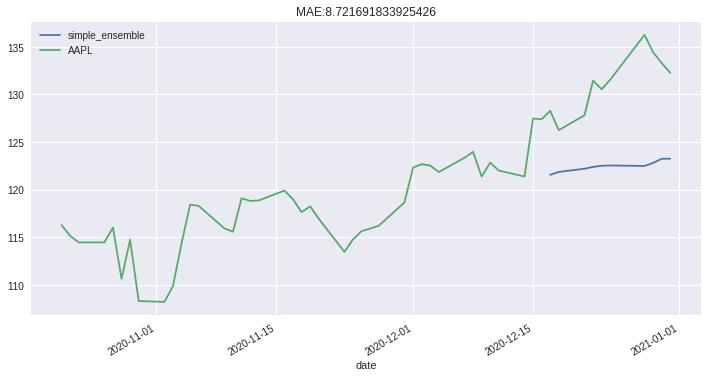

In [189]:
from hcrystalball.ensemble import SimpleEnsemble
from hcrystalball.wrappers import ProphetWrapper
from hcrystalball.wrappers import ExponentialSmoothingWrapper
from hcrystalball.wrappers import get_sklearn_wrapper
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# X, y = pd.DataFrame(index=df.index), df['Sales']

prophet = ProphetWrapper(
    extra_seasonalities = [{
        'name':'bi-weekly',
        'period': 14.,
        'fourier_order': 5,
        'prior_scale': 15.0,
        'mode': None
    }]
)

simple_ensemble = SimpleEnsemble(
    base_learners=[
        prophet,
        ExponentialSmoothingWrapper(),
        get_sklearn_wrapper(RandomForestRegressor, random_state=42)
    ],
    ensemble_func = 'median')

preds = (simple_ensemble.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)

preds.plot(title=f"MAE:{(preds['AAPL']-preds['simple_ensemble']).abs().mean()}");

## Stacking Ensembles

hcrystalball `StackingEnsemble` model is very similar to sklearn [StackingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingRegressor.html), nice explanation of the concept could be also found [here](http://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/). Unfortunately, the sklearn version of the `StackingEnsemble` doesn’t allow us to enrich the `meta_training_data` by other features than predictions of base learners.

In the case of time-series forecasts, the additional features are the key to enabling the `meta_model` to successfully learn when each model performs best. It’s often the case that some model performs better during specific days (i.e. weekends/holidays/spikes) and other is better during more stable periods. The goal is to combine them appropriately.

To do that you can specify `weekdays_as_features` as `True`, which will enrich the `meta_training_data` with the day of the week features. Another way how to improve the performance of the stacking ensemble is to take into account that some models perform better on short horizons, and some on longer ones. To take this effect into account the `horizons_as_features` can be set to `True`, which creates an additional column per each horizon and enables the meta\_model to learn this representation. Another important aspect of `StackingRegressor` is that to obtain `meta_model` which can generalize well - it needs to be fitted on out-of-sample predictions - `train_horizon` and `train_n_splits`. If you set `train_horizon`\=5 and`train_n_splits`\=4 then the training set for meta\_model will be 20 observations. It’s advisable to have `train_horizon` \* `train_n_splits` = training set for `meta_model` as big as possible and have `train_horizon` which will match the horizon of the `StackingEnsemble` itself.


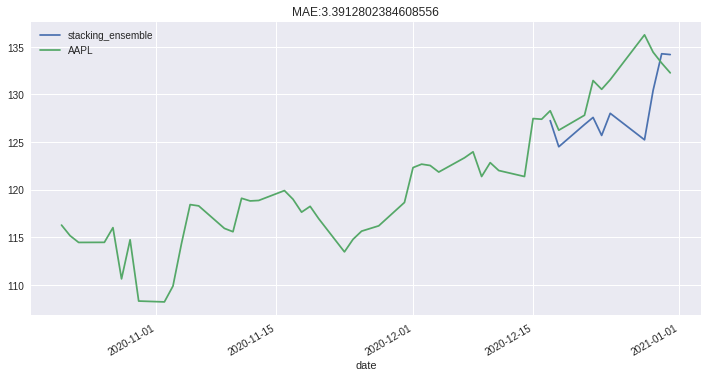

In [190]:
from hcrystalball.ensemble import StackingEnsemble

# X, y = pd.DataFrame(index=df.index), df['Sales']


stacking_ensemble = StackingEnsemble(
    base_learners=[
        prophet,
        ExponentialSmoothingWrapper(
            # prediction bounds for ExponentialSmoothingWrapper base_learner predictions
            # clip_predictions_lower=0.
            # clip_predictions_upper=50_000.
        ),
        get_sklearn_wrapper(
            RandomForestRegressor,
            random_state=42,
            # prediction bounds for RandomForestRegressor base_learner predictions
            # clip_predictions_lower=0.
            # clip_predictions_upper=50_000.
        )
    ],
    train_horizon=10,
    train_n_splits=3,
    meta_model=LinearRegression(),
    # prediction bounds for meta_model predictions
    # clip_predictions_lower=0.
    # clip_predictions_upper=50_000.
)
preds = (stacking_ensemble.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['stacking_ensemble']).abs().mean()}");

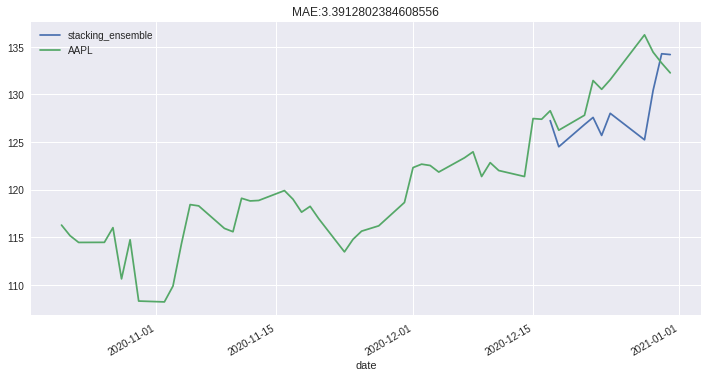

In [193]:
from hcrystalball.ensemble import StackingEnsemble

# X, y = pd.DataFrame(index=df.index), df['Sales']


stacking_ensemble = StackingEnsemble(
    base_learners=[
        prophet,
        ExponentialSmoothingWrapper(
            # prediction bounds for ExponentialSmoothingWrapper base_learner predictions
            clip_predictions_lower=0,
            clip_predictions_upper=50000,
        ),
        get_sklearn_wrapper(
            RandomForestRegressor,
            random_state=42,
            # prediction bounds for RandomForestRegressor base_learner predictions
            clip_predictions_lower=0,
            clip_predictions_upper=50000,
        )
    ],
    train_horizon=10,
    train_n_splits=3,
    meta_model=LinearRegression(),
    # prediction bounds for meta_model predictions
    # clip_predictions_lower=0.
    # clip_predictions_upper=50_000.
)
preds = (stacking_ensemble.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['stacking_ensemble']).abs().mean()}");

# Transforming Target
One of the common requirements is to transform the target variable itself. hcrystalball implements TargetTransformer transformer for such a cases, that internally scales input data and return un-scaled again.

In [194]:
from hcrystalball.wrappers import get_sklearn_wrapper
from hcrystalball.compose import TSColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from hcrystalball.preprocessing import TargetTransformer

## With Wrapper

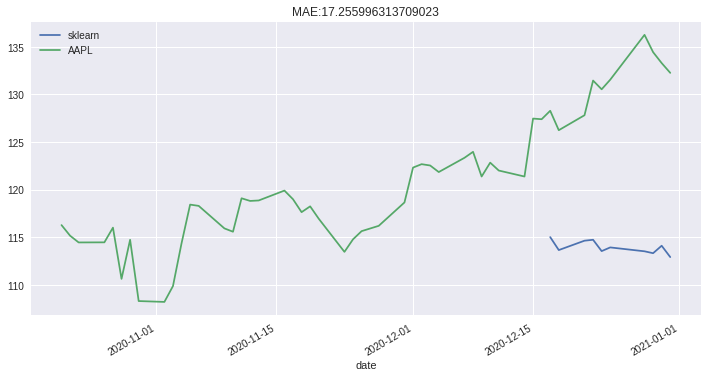

In [196]:
rf_model = get_sklearn_wrapper(RandomForestRegressor, random_state=42)
scaled = TargetTransformer(rf_model, StandardScaler())
preds = (scaled.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['sklearn']).abs().mean()}");

## With Pipeline

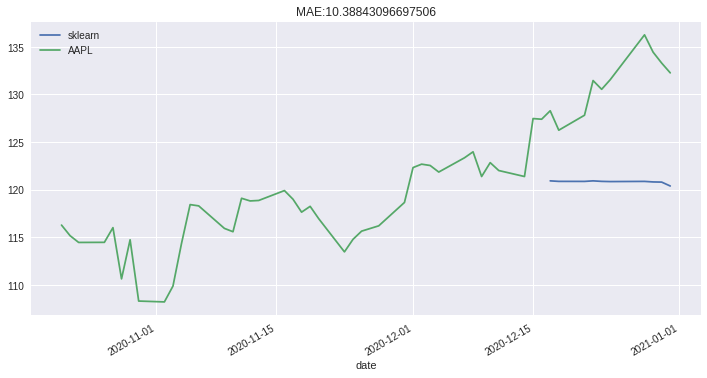

In [197]:
X['trend'] = np.arange(len(X))

# add standard scaler to the trend and let the date column pass in raw form
preprocessing = TSColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['trend'])
    ])

# define random forest model
rf_model = get_sklearn_wrapper(RandomForestRegressor, random_state=42)

# glue it together
sklearn_model_pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('model', rf_model)
])
scaled_pipeline = TargetTransformer(sklearn_model_pipeline, StandardScaler())
preds = (scaled_pipeline.fit(X[:-10], y[:-10])
         .predict(X[-10:])
         .merge(y, left_index=True, right_index=True, how='outer')
         .tail(50)
)
preds.plot(title=f"MAE:{(preds['AAPL']-preds['sklearn']).abs().mean()}");